In [1]:
# AIR QUALITY PREDICTION PIPELINE
# Complete implementation for DNN Assignment
# Author: Shashank Upadhyay (A023167024145)

"""
INSTALLATION COMMANDS (Run these first):
pip install pandas numpy scikit-learn tensorflow matplotlib seaborn ucimlrepo kaggle
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("AIR QUALITY PREDICTION PIPELINE - STARTING")
print("=" * 80)

# ============================================================================
# STEP 1: DATA LOADING
# ============================================================================

def load_uci_air_quality_dataset():
    """
    Load the UCI Air Quality Dataset
    This is the easiest dataset to start with - ready to use!
    """
    print("\n[STEP 1] Loading UCI Air Quality Dataset...")

    try:
        from ucimlrepo import fetch_ucirepo
        air_quality = fetch_ucirepo(id=360)
        df = air_quality.data.features
        print(f"✓ Dataset loaded successfully!")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"✗ Error loading UCI dataset: {e}")
        print("  Trying alternative method...")
        return load_from_url()

def load_from_url():
    """
    Alternative: Load from direct URL
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
    try:
        df = pd.read_csv(url, sep=';', decimal=',')
        print(f"✓ Dataset loaded from URL!")
        return df
    except:
        print("✗ Could not load dataset. Please download manually from:")
        print("  https://archive.ics.uci.edu/ml/datasets/Air+Quality")
        return None

def load_kaggle_dataset():
    """
    Alternative: Load Kaggle Air Quality India Dataset
    Requires: kaggle.json API key in ~/.kaggle/
    """
    print("\n[ALTERNATIVE] Loading Kaggle Dataset...")
    try:
        import kaggle
        kaggle.api.dataset_download_files('rohanrao/air-quality-data-in-india',
                                          path='./data', unzip=True)
        df = pd.read_csv('./data/city_day.csv')
        print(f"✓ Kaggle dataset loaded: {df.shape}")
        return df
    except:
        print("✗ Kaggle dataset not available. Using UCI dataset instead.")
        return None

# ============================================================================
# STEP 2: DATA PREPROCESSING
# ============================================================================

def preprocess_data(df):
    """
    Clean and prepare data for modeling
    """
    print("\n[STEP 2] Preprocessing Data...")

    # Handle missing values
    print(f"  Missing values before: {df.isnull().sum().sum()}")
    df = df.fillna(method='ffill').fillna(method='bfill')
    print(f"  Missing values after: {df.isnull().sum().sum()}")

    # Remove invalid values (marked as -200 in UCI dataset)
    df = df.replace(-200, np.nan)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_clean = df[numeric_cols].copy()

    print(f"✓ Data cleaned. Shape: {df_clean.shape}")
    return df_clean

def create_temporal_features(df):
    """
    Add time-based features for better prediction
    """
    print("\n[STEP 3] Creating Temporal Features...")

    # Create time index if not exists
    df['timestamp'] = pd.date_range(start='2004-03-10', periods=len(df), freq='H')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    print(f"✓ Temporal features added")
    return df

# ============================================================================
# STEP 3: SEQUENCE PREPARATION FOR LSTM
# ============================================================================

def create_sequences(data, target_col, lookback=168, forecast_horizon=24):
    """
    Create sequences for time series prediction
    lookback: hours of historical data (168 = 7 days)
    forecast_horizon: hours to predict ahead (24 = 1 day)

    For 2-week prediction, use:
    - lookback=336 (14 days)
    - forecast_horizon=336 (14 days)
    """
    print(f"\n[STEP 4] Creating Sequences...")
    print(f"  Lookback window: {lookback} hours ({lookback/24:.1f} days)")
    print(f"  Forecast horizon: {forecast_horizon} hours ({forecast_horizon/24:.1f} days)")

    X, y = [], []

    for i in range(lookback, len(data) - forecast_horizon):
        X.append(data[i-lookback:i])
        y.append(data[i:i+forecast_horizon, target_col])

    X = np.array(X)
    y = np.array(y)

    print(f"✓ Sequences created: X shape={X.shape}, y shape={y.shape}")
    return X, y

def prepare_model_data(df, target_column='CO(GT)', lookback=168, horizon=24):
    """
    Complete data preparation pipeline
    """
    print("\n[STEP 5] Preparing Model Data...")

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Get target column index
    target_idx = df.columns.get_loc(target_column)

    # Create sequences
    X, y = create_sequences(scaled_data, target_idx, lookback, horizon)

    # Train/test split (80/20)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"✓ Data prepared:")
    print(f"  Training: X={X_train.shape}, y={y_train.shape}")
    print(f"  Testing: X={X_test.shape}, y={y_test.shape}")

    return X_train, X_test, y_train, y_test, scaler

# ============================================================================
# STEP 4: BUILD DNN MODEL
# ============================================================================

def build_hybrid_lstm_cnn_model(input_shape, output_steps):
    """
    Hybrid CNN-LSTM architecture with Attention
    """
    print("\n[STEP 6] Building DNN Model...")

    inputs = keras.Input(shape=input_shape)

    # CNN layers for local pattern extraction
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Dropout(0.2)(x)

    # Bidirectional LSTM for temporal dependencies
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(output_steps)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    print(f"✓ Model built successfully!")
    print(f"\nModel Architecture:")
    model.summary()

    return model

# ============================================================================
# STEP 5: TRAIN MODEL
# ============================================================================

def train_model(model, X_train, y_train, X_test, y_test, epochs=50):
    """
    Train the model with early stopping
    """
    print("\n[STEP 7] Training Model...")

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    print("✓ Training completed!")
    return history

# ============================================================================
# STEP 6: EVALUATE MODEL
# ============================================================================

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance
    """
    print("\n[STEP 8] Evaluating Model...")

    predictions = model.predict(X_test)

    # Calculate metrics for each forecast step
    horizons = [1, 3, 7, 14]  # 1-day, 3-day, 7-day, 14-day

    print("\nPerformance Metrics:")
    print("-" * 60)

    for h in horizons:
        if h <= predictions.shape[1]:
            h_idx = h - 1
            mse = mean_squared_error(y_test[:, h_idx], predictions[:, h_idx])
            mae = mean_absolute_error(y_test[:, h_idx], predictions[:, h_idx])
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test[:, h_idx], predictions[:, h_idx])

            print(f"{h}-day ahead prediction:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE:  {mae:.4f}")
            print(f"  R²:   {r2:.4f}")
            print()

    return predictions

def plot_results(history, y_test, predictions, save_path='results.png'):
    """
    Visualize training history and predictions
    """
    print("\n[STEP 9] Generating Visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training history
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss Over Epochs')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Predictions vs Actual (1-day ahead)
    axes[0, 1].plot(y_test[:100, 0], label='Actual', alpha=0.7)
    axes[0, 1].plot(predictions[:100, 0], label='Predicted', alpha=0.7)
    axes[0, 1].set_title('1-Day Ahead Predictions')
    axes[0, 1].set_xlabel('Sample')
    axes[0, 1].set_ylabel('Normalized Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Scatter plot
    axes[1, 0].scatter(y_test[:, 0], predictions[:, 0], alpha=0.5)
    axes[1, 0].plot([y_test.min(), y_test.max()],
                    [y_test.min(), y_test.max()], 'r--')
    axes[1, 0].set_title('Actual vs Predicted (1-day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    axes[1, 0].grid(True)

    # Residuals
    residuals = y_test[:, 0] - predictions[:, 0]
    axes[1, 1].hist(residuals, bins=50)
    axes[1, 1].set_title('Prediction Residuals Distribution')
    axes[1, 1].set_xlabel('Residual')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Results saved to {save_path}")
    plt.show()

# ============================================================================
# MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """
    Complete pipeline execution
    """
    print("\n" + "="*80)
    print("STARTING COMPLETE AIR QUALITY PREDICTION PIPELINE")
    print("="*80)

    # 1. Load Data
    df = load_uci_air_quality_dataset()
    if df is None:
        print("ERROR: Could not load dataset. Exiting.")
        return

    # 2. Preprocess
    df_clean = preprocess_data(df)
    df_clean = create_temporal_features(df_clean)

    # 3. Prepare sequences
    # For 1-day prediction: lookback=168 (7 days), horizon=24 (1 day)
    # For 2-week prediction: lookback=336 (14 days), horizon=336 (14 days)

    X_train, X_test, y_train, y_test, scaler = prepare_model_data(
        df_clean,
        target_column='CO(GT)',
        lookback=168,  # 7 days of history
        horizon=24     # 1 day ahead prediction
    )

    # 4. Build Model
    model = build_hybrid_lstm_cnn_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_steps=y_train.shape[1]
    )

    # 5. Train
    history = train_model(model, X_train, y_train, X_test, y_test, epochs=50)

    # 6. Evaluate
    predictions = evaluate_model(model, X_test, y_test)

    # 7. Visualize
    plot_results(history, y_test, predictions)

    # 8. Save Model
    model.save('air_quality_model.h5')
    print("\n✓ Model saved as 'air_quality_model.h5'")

    print("\n" + "="*80)
    print("PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
    print("="*80)
    print("\nNext Steps:")
    print("1. Fine-tune hyperparameters (learning rate, layers, units)")
    print("2. Try different lookback windows (7 days, 14 days)")
    print("3. Experiment with different forecast horizons")
    print("4. Build REST API for deployment")
    print("5. Create web dashboard for visualization")

    return model, history, predictions, scaler

# ============================================================================
# RUN THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    model, history, predictions, scaler = main()

AIR QUALITY PREDICTION PIPELINE - STARTING

STARTING COMPLETE AIR QUALITY PREDICTION PIPELINE

[STEP 1] Loading UCI Air Quality Dataset...
✗ Error loading UCI dataset: No module named 'ucimlrepo'
  Trying alternative method...
✗ Could not load dataset. Please download manually from:
  https://archive.ics.uci.edu/ml/datasets/Air+Quality
ERROR: Could not load dataset. Exiting.


TypeError: cannot unpack non-iterable NoneType object

In [5]:
!pip install ucimlrepo

AIR QUALITY PREDICTION PIPELINE - STARTING

STARTING COMPLETE AIR QUALITY PREDICTION PIPELINE

[STEP 1] Loading UCI Air Quality Dataset...
✓ Dataset loaded successfully!
  Shape: (9357, 15)
  Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

[STEP 2] Preprocessing Data...
  Missing values before: 0
  Missing values after: 0
✓ Data cleaned. Shape: (9357, 13)

[STEP 3] Creating Temporal Features...
✓ Temporal features added

[STEP 5] Preparing Model Data...

[STEP 4] Creating Sequences...
  Lookback window: 168 hours (7.0 days)
  Forecast horizon: 24 hours (1.0 days)
✓ Sequences created: X shape=(9165, 168, 17), y shape=(9165, 24)
✓ Data prepared:
  Training: X=(7332, 168, 17), y=(7332, 24)
  Testing: X=(1833, 168, 17), y=(1833, 24)

[STEP 6] Building DNN Model...
✓ Model built successfully!

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 17)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 168, 64)        │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 168, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 168, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,880 (1.84 MB)

 Trainable params: 481,880 (1.84 MB)

 Non-trainable params: 0 (0.00 B)


[STEP 7] Training Model...
Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 0.0179 - mae: 0.0980 - val_loss: 0.0094 - val_mae: 0.0735 - learning_rate: 0.0010
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - loss: 0.0092 - mae: 0.0705 - val_loss: 0.0092 - val_mae: 0.0749 - learning_rate: 0.0010
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.0074 - mae: 0.0631 - val_loss: 0.0093 - val_mae: 0.0740 - learning_rate: 0.0010
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - loss: 0.0065 - mae: 0.0588 - val_loss: 0.0101 - val_mae: 0.0805 - learning_rate: 0.0010
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.0059 - mae: 0.0564 - val_loss: 0.0106 - val_mae: 0.0796 - learning_rate: 0.0010
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - loss: 0.0053 - mae: 0.0534 - val_loss: 0.0098 - val_mae: 0.0753 - learning_rate: 0.0010
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - loss: 0.0050 - mae: 0.0519 - val_loss: 0.0099 - val_mae: 0.

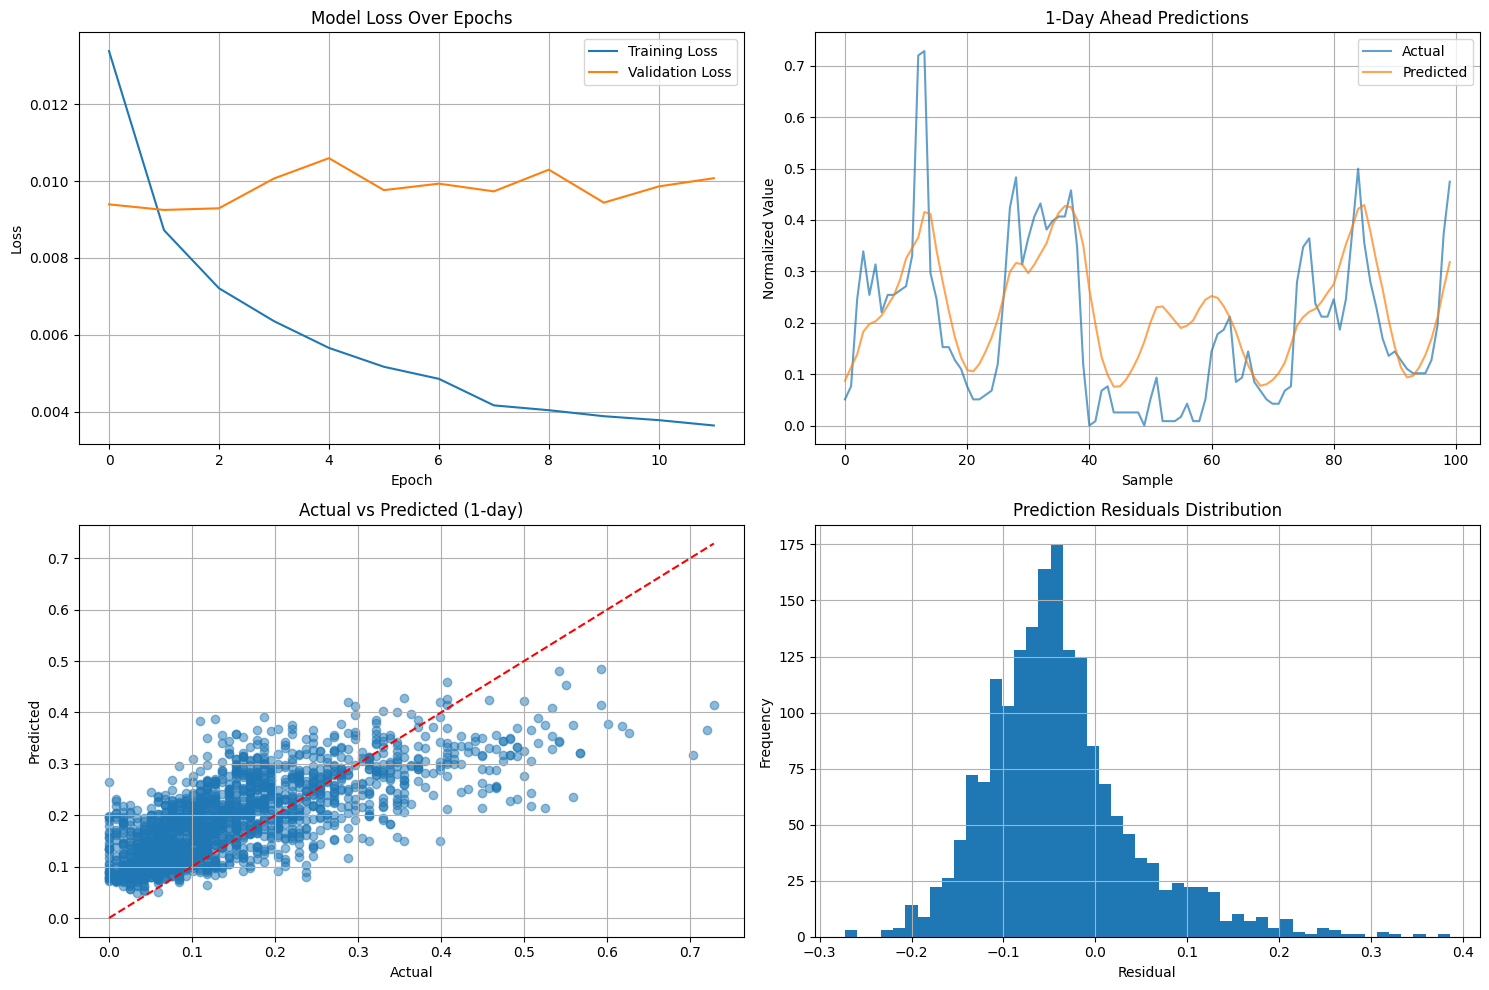


✓ Model saved as 'air_quality_model.h5'

PIPELINE EXECUTION COMPLETED SUCCESSFULLY!

Next Steps:
1. Fine-tune hyperparameters (learning rate, layers, units)
2. Try different lookback windows (7 days, 14 days)
3. Experiment with different forecast horizons
4. Build REST API for deployment
5. Create web dashboard for visualization


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("AIR QUALITY PREDICTION PIPELINE - STARTING")
print("=" * 80)

# ============================================================================
# STEP 1: DATA LOADING
# ============================================================================

def load_uci_air_quality_dataset():
    """
    Load the UCI Air Quality Dataset
    This is the easiest dataset to start with - ready to use!
    """
    print("\n[STEP 1] Loading UCI Air Quality Dataset...")

    try:
        from ucimlrepo import fetch_ucirepo
        air_quality = fetch_ucirepo(id=360)
        df = air_quality.data.features
        print(f"✓ Dataset loaded successfully!")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"✗ Error loading UCI dataset: {e}")
        print("  Trying alternative method...")
        return load_from_url()

def load_from_url():
    """
    Alternative: Load from direct URL
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
    try:
        df = pd.read_csv(url, sep=';', decimal=',')
        print(f"✓ Dataset loaded from URL!")
        return df
    except:
        print("✗ Could not load dataset. Please download manually from:")
        print("  https://archive.ics.uci.edu/ml/datasets/Air+Quality")
        return None

def load_kaggle_dataset():
    """
    Alternative: Load Kaggle Air Quality India Dataset
    Requires: kaggle.json API key in ~/.kaggle/
    """
    print("\n[ALTERNATIVE] Loading Kaggle Dataset...")
    try:
        import kaggle
        kaggle.api.dataset_download_files('rohanrao/air-quality-data-in-india',
                                          path='./data', unzip=True)
        df = pd.read_csv('./data/city_day.csv')
        print(f"✓ Kaggle dataset loaded: {df.shape}")
        return df
    except:
        print("✗ Kaggle dataset not available. Using UCI dataset instead.")
        return None

# ============================================================================
# STEP 2: DATA PREPROCESSING
# ============================================================================

def preprocess_data(df):
    """
    Clean and prepare data for modeling
    """
    print("\n[STEP 2] Preprocessing Data...")

    # Handle missing values
    print(f"  Missing values before: {df.isnull().sum().sum()}")
    df = df.fillna(method='ffill').fillna(method='bfill')
    print(f"  Missing values after: {df.isnull().sum().sum()}")

    # Remove invalid values (marked as -200 in UCI dataset)
    df = df.replace(-200, np.nan)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_clean = df[numeric_cols].copy()

    print(f"✓ Data cleaned. Shape: {df_clean.shape}")
    return df_clean

def create_temporal_features(df):
    """
    Add time-based features for better prediction
    """
    print("\n[STEP 3] Creating Temporal Features...")

    # Create time index if not exists
    df['timestamp'] = pd.date_range(start='2004-03-10', periods=len(df), freq='H')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    print(f"✓ Temporal features added")
    return df

# ============================================================================
# STEP 3: SEQUENCE PREPARATION FOR LSTM
# ============================================================================

def create_sequences(data, target_col, lookback=168, forecast_horizon=24):
    """
    Create sequences for time series prediction
    lookback: hours of historical data (168 = 7 days)
    forecast_horizon: hours to predict ahead (24 = 1 day)

    For 2-week prediction, use:
    - lookback=336 (14 days)
    - forecast_horizon=336 (14 days)
    """
    print(f"\n[STEP 4] Creating Sequences...")
    print(f"  Lookback window: {lookback} hours ({lookback/24:.1f} days)")
    print(f"  Forecast horizon: {forecast_horizon} hours ({forecast_horizon/24:.1f} days)")

    X, y = [], []

    for i in range(lookback, len(data) - forecast_horizon):
        X.append(data[i-lookback:i])
        y.append(data[i:i+forecast_horizon, target_col])

    X = np.array(X)
    y = np.array(y)

    print(f"✓ Sequences created: X shape={X.shape}, y shape={y.shape}")
    return X, y

def prepare_model_data(df, target_column='CO(GT)', lookback=168, horizon=24):
    """
    Complete data preparation pipeline
    """
    print("\n[STEP 5] Preparing Model Data...")

    # Get target column index before dropping it from df for scaling
    target_idx = df.columns.get_loc(target_column)

    # Drop 'timestamp' column as it's not numerical and will cause scaling issues
    # The temporal features (hour, day_of_week, month, is_weekend) are numerical and should be scaled.
    df_numerical = df.drop(columns=['timestamp']) # MODIFICATION HERE

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_numerical) # MODIFICATION HERE


    # Create sequences
    X, y = create_sequences(scaled_data, target_idx, lookback, horizon)

    # Train/test split (80/20)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"✓ Data prepared:")
    print(f"  Training: X={X_train.shape}, y={y_train.shape}")
    print(f"  Testing: X={X_test.shape}, y={y_test.shape}")

    return X_train, X_test, y_train, y_test, scaler

# ============================================================================
# STEP 4: BUILD DNN MODEL
# ============================================================================

def build_hybrid_lstm_cnn_model(input_shape, output_steps):
    """
    Hybrid CNN-LSTM architecture with Attention
    """
    print("\n[STEP 6] Building DNN Model...")

    inputs = keras.Input(shape=input_shape)

    # CNN layers for local pattern extraction
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Dropout(0.2)(x)

    # Bidirectional LSTM for temporal dependencies
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(output_steps)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    print(f"✓ Model built successfully!")
    print(f"\nModel Architecture:")
    model.summary()

    return model

# ============================================================================
# STEP 5: TRAIN MODEL
# ============================================================================

def train_model(model, X_train, y_train, X_test, y_test, epochs=50):
    """
    Train the model with early stopping
    """
    print("\n[STEP 7] Training Model...")

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    print("✓ Training completed!")
    return history

# ============================================================================
# STEP 6: EVALUATE MODEL
# ============================================================================

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance
    """
    print("\n[STEP 8] Evaluating Model...")

    predictions = model.predict(X_test)

    # Calculate metrics for each forecast step
    horizons = [1, 3, 7, 14]  # 1-day, 3-day, 7-day, 14-day

    print("\nPerformance Metrics:")
    print("-" * 60)

    for h in horizons:
        if h <= predictions.shape[1]:
            h_idx = h - 1
            mse = mean_squared_error(y_test[:, h_idx], predictions[:, h_idx])
            mae = mean_absolute_error(y_test[:, h_idx], predictions[:, h_idx])
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test[:, h_idx], predictions[:, h_idx])

            print(f"{h}-day ahead prediction:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE:  {mae:.4f}")
            print(f"  R²:   {r2:.4f}")
            print()

    return predictions

def plot_results(history, y_test, predictions, save_path='results.png'):
    """
    Visualize training history and predictions
    """
    print("\n[STEP 9] Generating Visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training history
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss Over Epochs')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Predictions vs Actual (1-day ahead)
    axes[0, 1].plot(y_test[:100, 0], label='Actual', alpha=0.7)
    axes[0, 1].plot(predictions[:100, 0], label='Predicted', alpha=0.7)
    axes[0, 1].set_title('1-Day Ahead Predictions')
    axes[0, 1].set_xlabel('Sample')
    axes[0, 1].set_ylabel('Normalized Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Scatter plot
    axes[1, 0].scatter(y_test[:, 0], predictions[:, 0], alpha=0.5)
    axes[1, 0].plot([y_test.min(), y_test.max()],
                    [y_test.min(), y_test.max()], 'r--')
    axes[1, 0].set_title('Actual vs Predicted (1-day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    axes[1, 0].grid(True)

    # Residuals
    residuals = y_test[:, 0] - predictions[:, 0]
    axes[1, 1].hist(residuals, bins=50)
    axes[1, 1].set_title('Prediction Residuals Distribution')
    axes[1, 1].set_xlabel('Residual')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Results saved to {save_path}")
    plt.show()

# ============================================================================
# MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """
    Complete pipeline execution
    """
    print("\n" + "="*80)
    print("STARTING COMPLETE AIR QUALITY PREDICTION PIPELINE")
    print("="*80)

    # 1. Load Data
    df = load_uci_air_quality_dataset()
    if df is None:
        print("ERROR: Could not load dataset. Exiting.")
        return None, None, None, None # Modified to return None for all expected values

    # 2. Preprocess
    df_clean = preprocess_data(df)
    df_clean = create_temporal_features(df_clean)

    # 3. Prepare sequences
    # For 1-day prediction: lookback=168 (7 days), horizon=24 (1 day)
    # For 2-week prediction: lookback=336 (14 days), horizon=336 (14 days)

    X_train, X_test, y_train, y_test, scaler = prepare_model_data(
        df_clean,
        target_column='CO(GT)',
        lookback=168,  # 7 days of history
        horizon=24     # 1 day ahead prediction
    )

    # 4. Build Model
    model = build_hybrid_lstm_cnn_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_steps=y_train.shape[1]
    )

    # 5. Train
    history = train_model(model, X_train, y_train, X_test, y_test, epochs=50)

    # 6. Evaluate
    predictions = evaluate_model(model, X_test, y_test)

    # 7. Visualize
    plot_results(history, y_test, predictions)

    # 8. Save Model
    model.save('air_quality_model.h5')
    print("\n✓ Model saved as 'air_quality_model.h5'")

    print("\n" + "="*80)
    print("PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
    print("="*80)
    print("\nNext Steps:")
    print("1. Fine-tune hyperparameters (learning rate, layers, units)")
    print("2. Try different lookback windows (7 days, 14 days)")
    print("3. Experiment with different forecast horizons")
    print("4. Build REST API for deployment")
    print("5. Create web dashboard for visualization")

    return model, history, predictions, scaler

# ============================================================================
# RUN THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    model, history, predictions, scaler = main()

In [8]:
# Download all important files
from google.colab import files

# 1. Download the trained model
files.download('air_quality_model.h5')

# 2. Download the results plot
files.download('results.png')

# 3. Download your notebook
!jupyter nbconvert --to notebook --output model_training.ipynb *.ipynb
files.download('Air Pollution.ipynb')

# 4. Save performance metrics to a file
with open('metrics.txt', 'w') as f:
    f.write("Training completed at Epoch 12 (Early Stopping)\n")
    f.write("=" * 60 + "\n")
    # Add your actual metrics here from the output

files.download('metrics.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[NbConvertApp] WARNING | pattern '*.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute t

FileNotFoundError: Cannot find file: Air Pollution.ipynb